Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Целевой признак - Price.

Признаки для обучения модели:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

# 1. Подготовка данных

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import xgboost as xgb

import math

from sklearn import metrics

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.utils import shuffle

from scipy.stats import randint
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore") 
import seaborn as sns 
pd.set_option('display.max_columns', None)
import scipy.stats as stats
import pylab

from random import randint
import random

In [2]:
df = pd.read_csv('/home/andrey/Datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
#посмотрим за какие сроки скачаны анкеты из базы
df['DateCreated'].sort_values()

61207     2014-03-10 00:00:00
4001      2015-03-20 00:00:00
342275    2015-06-18 00:00:00
86601     2015-08-07 00:00:00
175103    2015-08-10 00:00:00
                 ...         
134418    2016-04-07 00:00:00
176987    2016-04-07 00:00:00
206303    2016-04-07 00:00:00
309336    2016-04-07 00:00:00
305430    2016-04-07 00:00:00
Name: DateCreated, Length: 354369, dtype: object

В первую очередь удалим столбцы: $DateCrawled, LastSeen, DateCreated$ т.к. данные предоставлены за год они не повлияют на качество модели. Так же удалим $PostalCode$.

In [5]:
df = df.drop(['DateCrawled', 'LastSeen', 'DateCreated', 'PostalCode'], axis = 1)

#посмотрим на числовые столбцы
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0


В столбцах $Price, Power$  и  $RegistrationMonth$ однозначно есть нулевые значения их нужно будет обработать. 

Так же в столбце $RegistrationYear$, сразу видно аномальные значения с годом регистрации 1000 и 9999. 

В столбце $NumberOfPictures$ все значения заполнены нулями, скорее всего была ошибка при выгрузке базы объявлений, его придётся удалить.

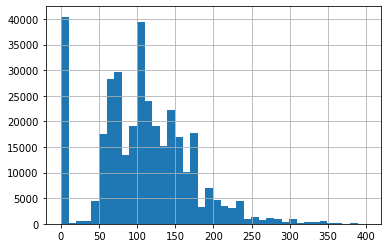

In [6]:
#удалим столбец NumberOfPictures
df = df.drop(['NumberOfPictures'], axis = 1)

#Посмотрим на распределение значений столбца "Power" отрежем ховст с выборасами в лошадиных силах
x = df.query('Power < 400')
x['Power'].hist(bins = 40)

Есть боллее 40 000 тысяч значений с 0 в значении мощность. И небольшое количество с выбросами в лошадиных силах более 400. Выбросы удалим.

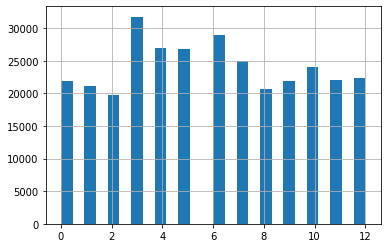

In [7]:
df = df.query('0 < Power < 400')
#Посмотрим на месяц регистриции
df['RegistrationMonth'].hist(bins = 26)

Так же более 35 тысяч значений заполнены 0, что скорее всего произошло из за того, что данные о месяце ригистрации ТС не были указаны в анкете. Заполним нули случайными значениями от 1 до 12.

In [8]:
#узнаем точное количество 0 значений
shape_RegistrationMonth = df[df['RegistrationMonth'] == 0].shape
#Создадим массив со случайными числами от 1 до 12 размером shape_RegistrationMonth 
np.random.seed(12345)
random_numbers = np.random.randint(1, 12, shape_RegistrationMonth[0])
#заменим нули на случайные числа в столцбе
df['RegistrationMonth'][df['RegistrationMonth'] == 0] = random_numbers

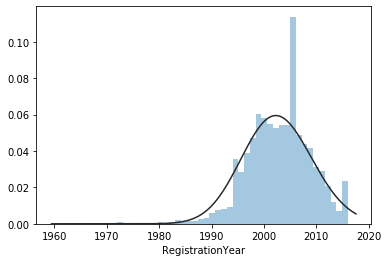

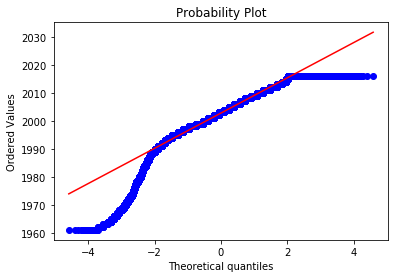

In [9]:
#посмотрим на значения в столбце RegistrationYear отрезав аномалии (ТС выпущенные ранее 1960 года, и зарегистрированные в 2017 и далее)
df = df.query('1960 < RegistrationYear < 2017')

#посмотрим на распределение
sns.distplot(df['RegistrationYear'], kde=False, fit=stats.gamma)
plt.show()
stats.probplot(df['RegistrationYear'], dist="norm", plot=pylab)
pylab.show()

In [10]:
#отбросим аномально низкие цены на авто (менее 200 евро)
df = df.query('200 < Price')

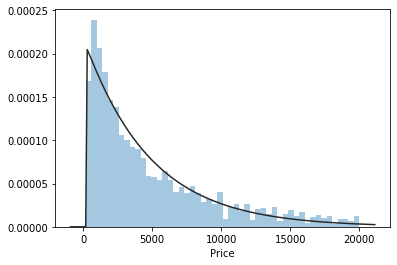

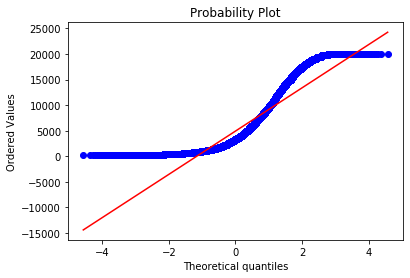

In [11]:
#посмотрим как распределены данные в столбце price

sns.distplot(df['Price'], kde=False, fit=stats.gamma)
plt.show()
stats.probplot(df['Price'], dist="norm", plot=pylab)
pylab.show()

In [12]:
#посмотрим количество Nanов в столбцах
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
NotRepaired,40944,0.140804
FuelType,14563,0.050081
Model,10644,0.036604
VehicleType,10114,0.034781
Gearbox,5017,0.017253
Brand,0,0.000000
RegistrationMonth,0,0.000000
Kilometer,0,0.000000
Power,0,0.000000
RegistrationYear,0,0.000000


Пропуски есть в категориальных признаках VehicleType, Gearbox, Model, FuelType, NotRepaired. 

# 2. Обучение моделей

In [13]:
#обучим модель линейной регрессией

#категориальные признаки обработаем с помощью ohe
df_ohe = pd.get_dummies(df, drop_first=True)

#масштабируем признаки
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

scaler = StandardScaler()
scaler.fit(df_ohe[numeric])


df_ohe[numeric] = scaler.transform(df_ohe[numeric])

In [14]:
#разделим выборку
y = df_ohe['Price']
X = df_ohe.drop(['Price'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=12345)

In [15]:
%%time
#linear regression
model = LinearRegression()

param = {"normalize" : [True, False],
         "fit_intercept" : [True, False],
        }

model_rscv = RandomizedSearchCV(model, param_distributions = param, scoring = "neg_mean_squared_error",
                             cv = 4, verbose = 0, random_state = 12345, n_jobs = -1, n_iter = 5)

model_lr = model_rscv.fit(X_train, y_train)

print("Лучшие гиперпараметры для модели линейной регрессии")
print()
print(model_lr.best_estimator_.get_params())

pred = model_lr.predict(X_test)
print()
print("RMSE", (mean_squared_error(y_test, pred))**.5)

Лучшие гиперпараметры для модели линейной регрессии

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': True}

RMSE 2578.169837904547
CPU times: user 7.32 s, sys: 759 ms, total: 8.08 s
Wall time: 19 s


In [23]:
%%time
xgb_clf = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)

parameters = {
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'n_estimators': [200, 300, 400, 500, 1000, 2000]}


xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "neg_mean_squared_error",
                             cv = 4, verbose = 3, random_state = 12345, n_jobs = 4)



model_xgboost = xgb_rscv.fit(X_train, y_train)

best_par = model_xgboost.best_estimator_.get_params()

preds = model_xgboost.predict(X_test)
print("Лучшие гиперпараметры для бустинга")
print()
print(model_xgboost.best_estimator_.get_params())
print("RMSE", (mean_squared_error(y_test, preds))**.5)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:  6.8min finished


Лучшие гиперпараметры для бустинга

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': 0, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.07, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)

# 3. Анализ моделей

Линейная регрессия показала лучшее время при обучении 19.9 секунд, но вместе с тем и худший показатель метрики RMSE 2578

Наилучший показатель метрики RMSE (1566) показала модель градиентного бустинга. При этом время на обучение составило 7 минут 48 секунд на лучших гиперпараметрах. Так же наблюдалось общее улучшение метрики при увеличении количества деревьев, но в данной задаче улучшение метрики в дальнейшем стоновится менее сильным при общем увеличении времени обучения модели.